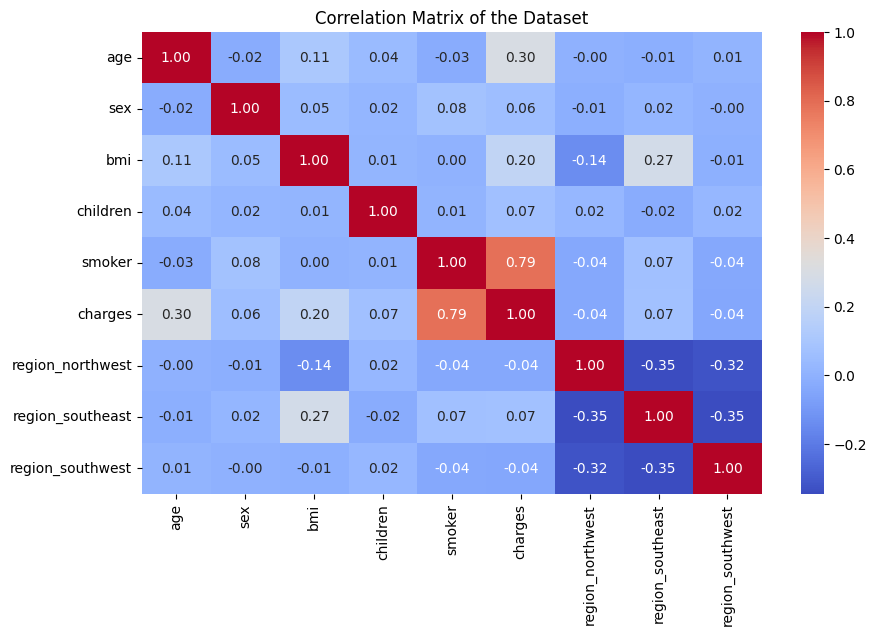

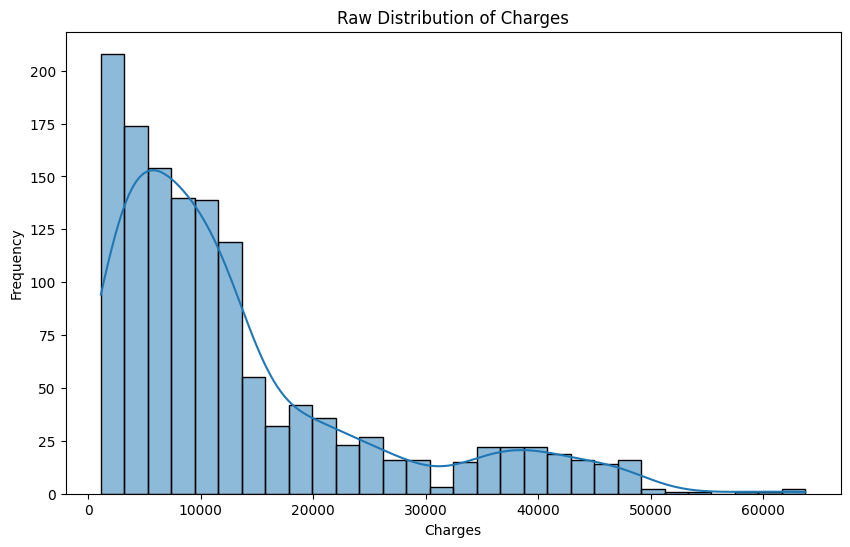

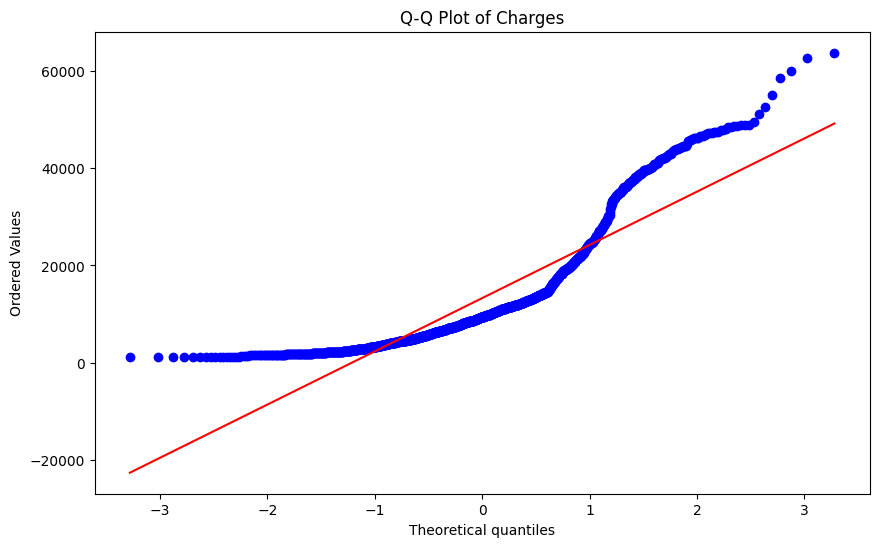

Shapiro-Wilk Test p-value: 1.1505226334932036e-36


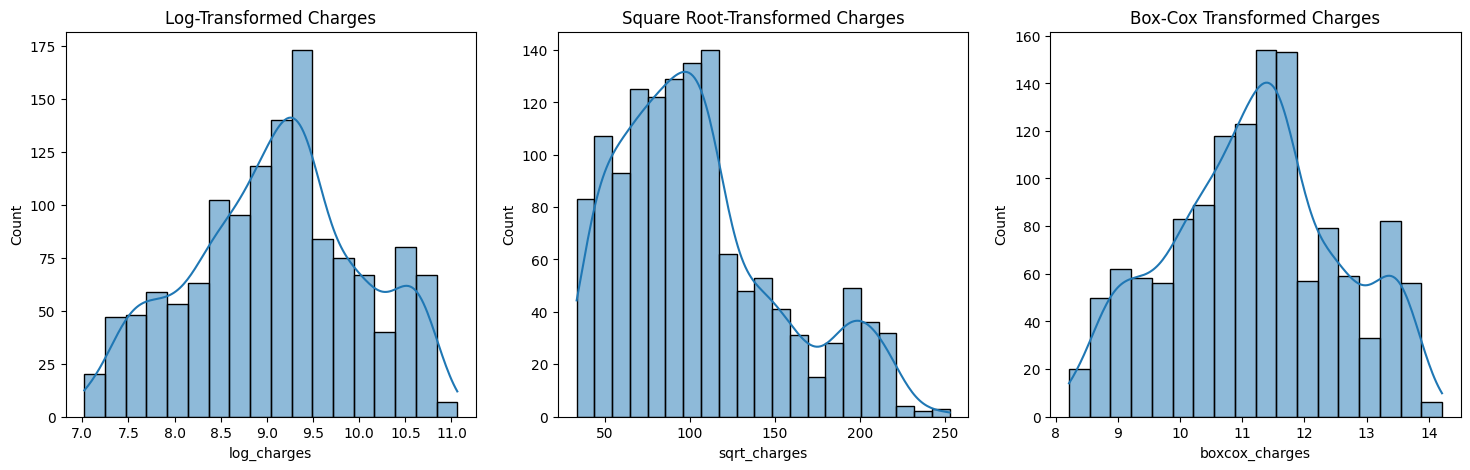

                   Model    RMSE  R2 Score
0      Linear Regression  0.4248    0.7845
1  Polynomial Regression  0.3640    0.8418
2       Lasso Regression  0.4294    0.7799
3       Ridge Regression  0.4249    0.7844
4  ElasticNet Regression  0.4275    0.7818
5         SGD Regression  0.4250    0.7843


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro, probplot, boxcox

# Load the dataset
data = pd.read_csv('/content/insurance.csv')

# 1. Dataset Summary
summary_stats = data.describe()
missing_values = data.isnull().sum()

# 2. Data Encoding
data_encoded = data.copy()
label_encoder = LabelEncoder()

# Label Encoding for 'sex' and 'smoker'
data_encoded['sex'] = label_encoder.fit_transform(data_encoded['sex'])
data_encoded['smoker'] = label_encoder.fit_transform(data_encoded['smoker'])

# One-Hot Encoding for 'region'
data_encoded = pd.get_dummies(data_encoded, columns=['region'], drop_first=True)

# 3. Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of the Dataset")
plt.show()

# 4. Histogram and Q-Q Plot for 'charges'
plt.figure(figsize=(10, 6))
sns.histplot(data_encoded['charges'], kde=True)
plt.title('Raw Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
probplot(data_encoded['charges'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Charges')
plt.show()

# 5. Shapiro-Wilk Test
shapiro_test = shapiro(data_encoded['charges'])
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

# 6. Transformations: Log, Square Root, and Box-Cox
data_encoded['log_charges'] = np.log(data_encoded['charges'])
data_encoded['sqrt_charges'] = np.sqrt(data_encoded['charges'])
data_encoded['boxcox_charges'], _ = boxcox(data_encoded['charges'] + 1)  # Adding 1 to avoid zero values

# Visualize the transformations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data_encoded['log_charges'], kde=True, ax=axes[0])
axes[0].set_title('Log-Transformed Charges')

sns.histplot(data_encoded['sqrt_charges'], kde=True, ax=axes[1])
axes[1].set_title('Square Root-Transformed Charges')

sns.histplot(data_encoded['boxcox_charges'], kde=True, ax=axes[2])
axes[2].set_title('Box-Cox Transformed Charges')

plt.show()

# 7. Splitting the dataset
X = data_encoded.drop(columns=['charges', 'log_charges', 'sqrt_charges', 'boxcox_charges'])
y = data_encoded['log_charges']  # Using log-transformed charges for regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 8. Training Various Regression Models
linear_regression = LinearRegression()
poly = PolynomialFeatures(degree=2)
lasso = Lasso(alpha=0.01)
ridge = Ridge(alpha=1)
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)
sgd = SGDRegressor(max_iter=2000, tol=1e-4, learning_rate='constant', eta0=0.001)

# Fit models
# Linear Regression (OLS)
linear_regression.fit(X_train, y_train)
y_pred_linear = linear_regression.predict(X_test)

# Polynomial Regression
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_regression = LinearRegression()
poly_regression.fit(X_train_poly, y_train)
y_pred_poly = poly_regression.predict(X_test_poly)

# Regularized Models
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elasticnet.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_elasticnet = elasticnet.predict(X_test)

# SGD Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sgd.fit(X_train_scaled, y_train)
y_pred_sgd = sgd.predict(X_test_scaled)

# 9. Evaluation of Models
results = {
    'Model': ['Linear Regression', 'Polynomial Regression', 'Lasso Regression', 'Ridge Regression', 'ElasticNet Regression', 'SGD Regression'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_linear)),
        np.sqrt(mean_squared_error(y_test, y_pred_poly)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_elasticnet)),
        np.sqrt(mean_squared_error(y_test, y_pred_sgd))
    ],
    'R2 Score': [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_poly),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_elasticnet),
        r2_score(y_test, y_pred_sgd)
    ]
}

# Display the results in a table
final_results_df = pd.DataFrame(results)
final_results_df = final_results_df.round({"RMSE": 4, "R2 Score": 4})
print(final_results_df)